In [1]:
## installations
%pip install pygeocodio
%pip install colorama
%pip install python-dotenv
%pip install CensusData
%pip install censusdata
%pip install census
!pip install us
%pip install mapclassify

## imports
from math import isnan
import os
import pandas as pd
from geocodio import GeocodioClient
import requests
import sqlalchemy
import numpy as np

from colorama import Fore, Style
from inspect import getframeinfo, stack
import smtplib, ssl
from datetime import datetime
from pytz import timezone
from sqlalchemy import create_engine

from dotenv import load_dotenv
load_dotenv()
import pickle
import geopandas as gpd
import censusdata as cd
from census import Census

## some additional
import pathlib
import re
#import geoplot as gplt
import mapclassify as mc

%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay, sjoin
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## keys
key = "a00cb79ec4f97e6760c49740b8ea7a7be6b77bb"
client = GeocodioClient(key)
censuskey = "8105419cada33ca0aaa48b111b8c44b9484e286a"

## multiple printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 132 kB 3.0 MB/s eta 0:00:01
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11927 sha256=6785c5239b29319c3283ce193e48cc656e206915d23479a5160d44021a23510e
  Stored in directory: /Users/Eden/Library/Caches/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-macosx_10_15_x86_64.whl size=23250 sha256=3c4ec6325a7ec565e0321e2487a714e2a5223f9c7d99b0e4ce2b506f17608b27
  Stored in directory: /Users/Eden/Library/Caches/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf

# Functions

In [2]:
def myprint(message, is_red="", email_also=""):
    try:
        if email_also != "yes":
            frameinfo = getframeinfo((stack()[1][0]))
            file_and_line_info = Fore.LIGHTBLUE_EX + "  (" + frameinfo.filename.split("/")[-1] + ", line " + str(frameinfo.lineno) + ")" + Style.RESET_ALL
        else:
            file_and_line_info = ""
        if is_red == "red":
            print_red(message + file_and_line_info)
        else:
            print(message + file_and_line_info)
    except:
        print(message + "(there was an error with `myprint`)")
        
def create_address_from(address, city, state, zip):
    return handle_null(address) + ", " + handle_null(city) + " " + handle_null(state) + " " + handle_null(str(zip))

def handle_null(object):
    if pd.isnull(object):
        return ""
    else:
        return str(object)
    
def split_into_parts(a_list, max_items_per_part):
    if len(a_list) < max_items_per_part:
        return [a_list]
    else:
        num_parts = len(a_list) // max_items_per_part
        res = []
        start = 0
        end = max_items_per_part
        for num in range(num_parts):
            res.append(a_list[start:end])

            if num != num_parts - 1:
                start += max_items_per_part
                end += max_items_per_part

        res.append(a_list[end:])
        return res

In [3]:
# geocodes a DataFrame `df`, adding columns for latitude, longitude, accuracy, and accuracy type
# worksite_or_housing is either "worksite" or "housing" and specifies whether to geocode housing or worksite columns
# if `check_previously_geocoded, uses the materialized postgres view `previously_geocoded` to geocode addresses that
# we've already geocoded without using Geocodio so as to save credits
# return the DataFrame with geocoding results columns added

def geocode_table(df, worksite_or_housing, check_previously_geocoded=False):
    myprint(f"Geocoding {worksite_or_housing}...")

    if check_previously_geocoded:
        make_query("REFRESH MATERIALIZED VIEW previously_geocoded")
        
        if worksite_or_housing == "worksite":
            df["address_id"] = df.apply(lambda job: (handle_null(job["street_addr_1_txt"]) + handle_null(job["cty_nm"]) +
                                                     handle_null(job["st_cd"]) + handle_null(job["zip_cd"])).lower(), axis=1)
        else:
            df["address_id"] = df.apply(lambda job: (handle_null(job["HOUSING_ADDRESS_LOCATION"]) + handle_null(job["HOUSING_CITY"]) +
                                                     handle_null(job["HOUSING_STATE"]) + handle_null(job["HOUSING_POSTAL_CODE"])).lower(), axis=1)
        df["previously_geocoded"] = False
        df[f"{worksite_or_housing}_lat"] = None
        df[f"{worksite_or_housing}_long"] = None
        df[f"{worksite_or_housing} accuracy"] = None
        df[f"{worksite_or_housing} accuracy type"] = ""

        errors = 0
        for i, job in df.iterrows():
            # won't work if the full address has certain special characters. should probably fix this but it's rather rare
            try:
                previous_geocode = pd.read_sql(f"""SELECT * FROM previously_geocoded WHERE full_address = '{job["address_id"]}'""", con=engine)
            except:
                previous_geocode = pd.DataFrame()
                print(f"""Failed to query previously_geocoded for address '{job["address_id"]}', the {i + 1}th row.""")
                errors += 1
            if not previous_geocode.empty:
                myprint(f"""'{job["address_id"]}' - the {i + 1}th row - is previously geocoded.""")
                assert len(previous_geocode) == 1
                df.at[i, f"{worksite_or_housing}_lat"] = get_value(previous_geocode, "latitude")
                df.at[i, f"{worksite_or_housing}_long"] = get_value(previous_geocode, "longitude")
                df.at[i, f"{worksite_or_housing} accuracy"] = get_value(previous_geocode, "accuracy")
                df.at[i, f"{worksite_or_housing} accuracy type"] = get_value(previous_geocode, "accuracy_type")
                df.at[i, "previously_geocoded"] = True

        print(f"There were {errors} errors checking for previous geocoding.")
        df = df.drop(columns=["address_id"])

        previously_geocoded = df[df["previously_geocoded"]]
        df = df[~(df["previously_geocoded"])]

        print(f"{len(previously_geocoded)} rows have already been geocoded and {len(df)} rows still need to be geocoded.")

        df = df.drop(columns=["previously_geocoded"])
        previously_geocoded.drop(columns=["previously_geocoded"], inplace=True)

    if not df.empty:

        if worksite_or_housing == "worksite":
            addresses = df.apply(lambda job: create_address_from(job["street_addr_1_txt"], job["cty_nm"], job["st_cd"], job["zip_cd"]), axis=1).tolist()
        elif worksite_or_housing == "housing":
            addresses = df.apply(lambda job: create_address_from(job["HOUSING_ADDRESS_LOCATION"], job["HOUSING_CITY"], job["HOUSING_STATE"], job["HOUSING_POSTAL_CODE"]), axis=1).tolist()
        else:
            print_red_and_email("`worksite_or_housing` parameter in geocode_table function must be either `worksite` or `housing` or `housing addendum`", "Invalid Function Parameter")
            return

        # handles case of more than 10000 addresses - because geocodio api won't batch geocode with more than 10000 addresses at once
        addresses_split = split_into_parts(addresses, 9999)
        geocoding_results = []
        for these_addresses in addresses_split:
            geocoding_results += client.geocode(these_addresses)
        assert len(geocoding_results) == len(addresses)


        latitudes, longitudes, accuracies, accuracy_types, i = [], [], [], [], 0
        for result in geocoding_results:
            try:
                results = result['results'][0]
                accuracies.append(results['accuracy'])
                accuracy_types.append(results['accuracy_type'])
                latitudes.append(results['location']['lat'])
                longitudes.append(results['location']['lng'])
            except:
                accuracies.append(None)
                accuracy_types.append(None)
                latitudes.append(None)
                longitudes.append(None)
            i +=1

        i = len(df.columns)
        df[f"{worksite_or_housing}_lat"] = latitudes
        df[f"{worksite_or_housing}_long"] = longitudes
        df[f"{worksite_or_housing} accuracy"] = accuracies
        df[f"{worksite_or_housing} accuracy type"] = accuracy_types
        myprint(f"Finished geocoding {worksite_or_housing}.")

    if check_previously_geocoded:
        df = df.append(previously_geocoded)

    # # uncomment to save excel file with geocoding results
    # now = datetime.now(tz=timezone('US/Eastern')).strftime("%I.%M%.%S_%p_%B_%d_%Y")
    # df.to_excel(f"geocoded_{now}.xlsx")
    # myprint("Backed up geocoding results")

    return df

# geocodes `df` and returns two dataframes - one with accuratly geocoded rows and one with inaccurate rows
def geocode_and_split_by_accuracy(df, table=""):
    if table == "dol_h2b":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
    elif table == "housing addendum":
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    elif table == "dol_h2a":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    else:
        df = geocode_table(df, "worksite")
        if "HOUSING_ADDRESS_LOCATION" in df.columns:
            df = geocode_table(df, "housing")
        else:
            print_red_and_email("Not geocoding housing because HOUSING_ADDRESS_LOCATION is not present. This should be fine, and hopefully just means there were only H-2B jobs in today's run, but you may want to check.", "Not geocoding housing today")

    housing_addendum = (table == "housing addendum")
    accurate = df.apply(lambda job: is_accurate(job, housing_addendum=housing_addendum), axis=1)
    accurate_jobs, inaccurate_jobs = df.copy()[accurate], df.copy()[~accurate]
    inaccurate_jobs["fixed"] = False

    myprint(f"There were {len(accurate_jobs)} accurate jobs.\nThere were {len(inaccurate_jobs)} inaccurate jobs.")

    return accurate_jobs, inaccurate_jobs

def geocode_onestate(data, abbr):
    df = data[data["st_cd"] == abbr].copy()
    geo_tab = geocode_table(df, "worksite", check_previously_geocoded=False)
    gdf = gpd.GeoDataFrame(geo_tab, 
                             geometry=gpd.points_from_xy(geo_tab.worksite_long, geo_tab.worksite_lat))
    return(gdf)


def demographics(variables_list, state_code, year = 2016):
    list_dem = c.acs5.state_county_tract(
        variables_list,
        state_fips=state_code,
        year = year,
        county_fips=Census.ALL,
        tract=Census.ALL)
    df = pd.DataFrame(list_dem)
    return df

# Step 1: load raw violations data and geocode

In [4]:
url = "https://enfxfr.dol.gov/data_catalog/WHD/whd_whisard_20210415.csv.zip"
raw_dol = pd.read_csv(url, 
                      index_col=None,
                      dtype={7:'string'})
raw_dol['findings_start_date'] = pd.to_datetime(raw_dol['findings_start_date'], errors='coerce')
raw_dol['findings_end_date'] = pd.to_datetime(raw_dol['findings_end_date'], errors='coerce')
print(f'raw dataframe has {len(raw_dol.columns)} columns and {len(raw_dol)} rows')

raw dataframe has 110 columns and 313928 rows


In [5]:
list_states= ['TX', 'MS', 'LA', 'KY', 'AL', 'TN']
raw_dol_states = raw_dol[raw_dol["st_cd"].isin(list_states)]
raw_dol_states = raw_dol_states[raw_dol_states["h2a_violtn_cnt"] > 0]
raw_dol_states = raw_dol_states[raw_dol_states["ld_dt"] >= "2016-1-1"]
print(f'When we subset to catchment state H2A violations and post 2016, we have {raw_dol_states.shape[0]} rows')

When we subset to catchment state H2A violations and post 2016, we have 329 rows


In [7]:
## path names
PATH_TO_DROPBOX = "../"

## intermediate outputs
PATH_TO_INT_OUTPUTS = PATH_TO_DROPBOX
PATH_TO_RAW_INPUTS = PATH_TO_DROPBOX + "raw/"


MS_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "MS.p", "rb"))
AL_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "AL.p", "rb"))
TX_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TX.p", "rb"))
KY_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "KY.p", "rb"))
TN_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TN.p", "rb"))
LA_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "LA.p", "rb"))

# Step 2: load tract shapefiles and code each investigation lat/long to its census tract

In [8]:
PATH_TO_DROPBOX = "../"

## intermediate outputs
PATH_TO_INT_OUTPUTS = "../"
#PATH_TO_RAW_INPUTS = PATH_TO_DROPBOX + "raw/"

RUN_GEOCODER = False
if RUN_GEOCODER:
    for one_state in list_states:
        print("starting geocoding for state: " + one_state)
        one_state_result = geocode_onestate(raw_dol_states, one_state)
        path_topickle = PATH_TO_INT_OUTPUTS + one_state + ".p"
        with open(path_topickle, "wb") as name:
            pickle.dump(one_state_result, name)
        name.close()
        print("wrote results for state: " + one_state)
else:
    all_point_pickles = [file for file in os.listdir(PATH_TO_INT_OUTPUTS)
                         if re.match("[A-Z][A-Z].p", file)]
    print("Available pickle files: " + "; ".join(all_point_pickles))
    ## fairly manual but could revise to make more general though tricky with obj naming
    ## reads each pkl from intermediate dir in Dropbox
    MS_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "MS.p", "rb"))
    AL_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "AL.p", "rb"))
    TX_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TX.p", "rb"))
    KY_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "KY.p", "rb"))
    TN_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TN.p", "rb"))
    LA_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "LA.p", "rb"))
    print("Finished reading in pickles")

Available pickle files: MS.p; LA.p; KY.p; TN.p; TX.p; AL.p
Finished reading in pickles


In [9]:
al_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_01_tract")
ky_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_21_tract")
la_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_22_tract")
ms_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_28_tract")
tn_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_47_tract")
tx_shapes = gpd.read_file(PATH_TO_INT_OUTPUTS + "tl_2016_48_tract")

In [10]:
shapefile_crs = tx_shapes.crs

In [11]:
## intersections while setting the CRS/projection of the 
## points to match the shapefiles CRS; could be made more efficient
## by storing the points and shapes in a length-2 list and then 
## putting that list in a dict with state as key
al_join = sjoin(AL_points.set_crs(shapefile_crs), al_shapes, how="right", op = "intersects")
ky_join = sjoin(KY_points.set_crs(shapefile_crs), ky_shapes, how="right", op = "intersects")
ms_join = sjoin(MS_points.set_crs(shapefile_crs), ms_shapes, how="right", op = "intersects")
la_join = sjoin(LA_points.set_crs(shapefile_crs), la_shapes, how="right", op = "intersects")
tx_join = sjoin(TX_points.set_crs(shapefile_crs), tx_shapes, how="right", op = "intersects")
tn_join = sjoin(TN_points.set_crs(shapefile_crs), tn_shapes, how="right", op = "intersects")

# Step 3: pull ACS demographics

In [153]:
c = Census(censuskey)
## "B01003_001E" = total
## "B03001_003E" = number of hispanic people
## "B06012_002E" = number of people at or below the poverty line
## "B07007_005E" = Geographical Mobility in the Past Year by Citizenship Status for Current 
    ##Residence in the United States:
    ## Estimate!!Total!!Foreign born!!Not a U.S. citizen
var_names = ["B03001_003E", "B01003_001E", "NAME", "B06012_002E", "B07007_005E"]

texas_dem = demographics(var_names, "48")
mississippi_dem = demographics(var_names, "28")
louisiana_dem = demographics(var_names, "22")
alabama_dem = demographics(var_names, "01")
tennessee_dem = demographics(var_names, "47")
kentucky_dem = demographics(var_names, "21")

# Step 4: merge demographics onto all tracts, regardless of count of violations

## 4.1 rowbind demographics and calculate percentages

In [154]:
all_dem = pd.concat([texas_dem, mississippi_dem, louisiana_dem, alabama_dem, tennessee_dem, kentucky_dem])
all_dem["perc_hispanic"] = all_dem["B03001_003E"]/all_dem["B01003_001E"]
all_dem["perc_bpl"] = all_dem["B06012_002E"]/all_dem["B01003_001E"]
all_dem["perc_mobile"] = all_dem["B07007_005E"]/all_dem["B01003_001E"]
all_dem["state_abbrv"] = all_dem["state"].replace({"48": "TX", "28": "MS", "22": "LA", 
                                                   "01": "AL", "47": "TN", "21": "KY"})
all_dem["GEOID_pasted"] = all_dem.state.astype(str) + \
                        all_dem.county.astype(str) + all_dem.tract.astype(str)

## 4.2 Merge demographics onto spatial dataframe with tract geometries, retaining all tracts

In [155]:
all_spatial_tracts = pd.concat([al_join, ky_join, la_join, tx_join,
                               tn_join, ms_join])

In [15]:
print(type(all_spatial_tracts))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [156]:
all_tracts_wdem = pd.merge(all_dem,
                          all_spatial_tracts,
                          how = "left",
                          left_on = "GEOID_pasted",
                          right_on = "GEOID",
                          suffixes = ["_acsdem", "_tracts"], 
                        indicator = "in_tracts")
all_tracts_wdem.in_tracts.value_counts()
print("Before merging, we had {} Census tracts with demographics".format(len(all_dem.GEOID_pasted.unique())))
print("After merging with polygons, we have {} tracts with demographics".format(len(all_tracts_wdem.GEOID_pasted.unique())))

both          10967
right_only        0
left_only         0
Name: in_tracts, dtype: int64

Before merging, we had 10870 Census tracts with demographics
After merging with polygons, we have 10870 tracts with demographics


## 4.3 Code places to zero violations if not in the spatial points data

In [157]:
## subsets to one with non-zero count of violations so no zeros
raw_dol_states.h2a_violtn_cnt.value_counts(dropna = False)

## after merge, includes NA or tracts without violations
all_tracts_wdem.h2a_violtn_cnt.value_counts(dropna = False)

all_tracts_wdem['h2_viol_include0'] = all_tracts_wdem['h2a_violtn_cnt'].fillna(0, inplace = False)
all_tracts_wdem.h2_viol_include0.value_counts(dropna = False)

1      71
2      43
3      31
4      18
5      17
       ..
31      1
30      1
29      1
22      1
464     1
Name: h2a_violtn_cnt, Length: 71, dtype: int64

NaN      10638
1.0         71
2.0         43
3.0         31
4.0         18
         ...  
82.0         1
110.0        1
358.0        1
100.0        1
70.0         1
Name: h2a_violtn_cnt, Length: 72, dtype: int64

0.0      10638
1.0         71
2.0         43
3.0         31
4.0         18
         ...  
82.0         1
110.0        1
358.0        1
100.0        1
70.0         1
Name: h2_viol_include0, Length: 72, dtype: int64

## 4.4 Create aggregation of violations to tract level and merge with tract polygon
* Group by census tract
* Find total count of H2A violations (sum of the include 0 measure)
* Find total count of places with H2A violations (sum of any > 0)

In [160]:
### data for shading: perc hispanic + viol summary by tract
count_viols_bytract = all_tracts_wdem.groupby('GEOID').agg({'h2_viol_include0': [np.sum, 
                                                        lambda x: sum(x != 0)],
                                                        'perc_hispanic': np.mean,
                                                        'perc_bpl': np.mean,
                                                        "perc_mobile": np.mean,
                                                        'state_abbrv': lambda x: x.unique()}).reset_index()

count_viols_bytract.columns = ['GEOID', 'total_tract_violations', 'total_tract_investigations_wviol', "perc_hispanic", "perc_bpl", "perc_mobile", "state_abbrv"]
count_viols_bytract.head() # max is 716 violations in that tract; 8 unique investigations
count_viols_bytract.describe()


## merge back on:
## tract polygon
## and make sure geodataframe
count_viols_bytract_wpoly = gpd.GeoDataFrame(pd.merge(count_viols_bytract,
                                    all_spatial_tracts[['GEOID', 'geometry']],
                                    how = "left",
                                    on = "GEOID"),
                                geometry = 'geometry')
## add tract centroid as a column
## in case you need point location at tract level
## based on here this is using a metric CRS rather than the shapefile CRS: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
count_viols_bytract_wpoly['tract_centroid'] = count_viols_bytract_wpoly.geometry.to_crs(epsg = 3395).centroid
count_viols_bytract_wpoly.head()

GEOID  total_tract_violations  total_tract_investigations_wviol  \
0  01001020100                     0.0                               0.0   
1  01001020200                     0.0                               0.0   
2  01001020300                     0.0                               0.0   
3  01001020400                     0.0                               0.0   
4  01001020500                     0.0                               0.0   

   perc_hispanic  perc_bpl  perc_mobile state_abbrv  
0       0.026368  0.099005     0.012438          AL  
1       0.012750  0.219945     0.006375          AL  
2       0.072704  0.107462     0.024872          AL  
3       0.088977  0.027394     0.006794          AL  
4       0.009498  0.094786     0.020705          AL

total_tract_violations  total_tract_investigations_wviol  \
count            10870.000000                      10870.000000   
mean                 0.741490                          0.030267   
std                 14.882932                          0.250318   
min                  0.000000                          0.000000   
25%                  0.000000                          0.000000   
50%                  0.000000                          0.000000   
75%                  0.000000                          0.000000   
max                716.000000                          8.000000   

       perc_hispanic      perc_bpl   perc_mobile  
count   10780.000000  10780.000000  10780.000000  
mean        0.206977      0.187573      0.062902  
std         0.263416      0.124572      0.082142  
min         0.000000      0.000000      0.000000  
25%         0.020740      0.093171      0.007486  
50%         0.086414      0.163220      0.029930  
75%         0.291376      0.258350      0.084892  
max         1.000000      1.000000      0.656504

GEOID  total_tract_violations  total_tract_investigations_wviol  \
0  01001020100                     0.0                               0.0   
1  01001020200                     0.0                               0.0   
2  01001020300                     0.0                               0.0   
3  01001020400                     0.0                               0.0   
4  01001020500                     0.0                               0.0   

   perc_hispanic  perc_bpl  perc_mobile state_abbrv  \
0       0.026368  0.099005     0.012438          AL   
1       0.012750  0.219945     0.006375          AL   
2       0.072704  0.107462     0.024872          AL   
3       0.088977  0.027394     0.006794          AL   
4       0.009498  0.094786     0.020705          AL   

                                            geometry  \
0  POLYGON ((-86.51038 32.47225, -86.51031 32.472...   
1  POLYGON ((-86.48127 32.47744, -86.48126 32.477...   
2  POLYGON ((-86.47087 32.47573, -86.47084 32.475...   
3  POLYGON ((-86.45394 32.49318, -86.45372 32.493...   
4  POLYGON ((-86.43842 32.44973, -86.43838 32.449...   

                     tract_centroid  
0  POINT (-9628031.161 3803171.314)  
1  POINT (-9626172.077 3802785.422)  
2  POINT (-9624704.284 3802940.363)  
3  POINT (-9622860.260 3802490.475)  
4  POINT (-9620526.662 3800761.563)

## 4.5 For places with any violations, merge that aggregated data onto worksite lat/long

In [161]:
exact_viol_location_wtract = pd.merge(all_spatial_tracts.loc[all_spatial_tracts.case_id.notnull(),
                                    ['case_id', 'worksite_lat',
                                    'worksite_long', 'GEOID', 'h2a_violtn_cnt']], # can add more cols here
                                    count_viols_bytract_wpoly,
                                    on = "GEOID",
                                    how = "left").drop_duplicates()

## here discusses alternate way for lat/long -> points: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
exact_viol_location_wtract['geometry'] = [Point(xy) for xy in
                                                zip(exact_viol_location_wtract['worksite_long'],
                                                exact_viol_location_wtract['worksite_lat'])]

exact_viol_location_wtract.head()

case_id  worksite_lat  worksite_long        GEOID  h2a_violtn_cnt  \
0   1860004.0     32.874088     -86.707798  01021060600             1.0   
3   1696089.0     32.773909     -86.719443  01021060600            73.0   
6   1860009.0     32.780891     -86.722257  01021060600            17.0   
9   1860006.0     32.850183     -86.626817  01021060102             3.0   
11  1860016.0     32.858844     -86.640349  01021060102             1.0   

    total_tract_violations  total_tract_investigations_wviol  perc_hispanic  \
0                     91.0                               3.0       0.054638   
3                     91.0                               3.0       0.054638   
6                     91.0                               3.0       0.054638   
9                      4.0                               2.0       0.064841   
11                     4.0                               2.0       0.064841   

    perc_bpl  perc_mobile state_abbrv                    geometry  \
0   0.159149     0.007306          AL  POINT (-86.70780 32.87409)   
3   0.159149     0.007306          AL  POINT (-86.71944 32.77391)   
6   0.159149     0.007306          AL  POINT (-86.72226 32.78089)   
9   0.239526     0.057291          AL  POINT (-86.62682 32.85018)   
11  0.239526     0.057291          AL  POINT (-86.64035 32.85884)   

                      tract_centroid  
0   POINT (-9655658.081 3842016.697)  
3   POINT (-9655658.081 3842016.697)  
6   POINT (-9655658.081 3842016.697)  
9   POINT (-9646617.749 3855047.759)  
11  POINT (-9646617.749 3855047.759)

## 4.6 Write pkl to intermediate folder in Dropbox

In [25]:
count_viols_bytract_wpoly.to_pickle(PATH_TO_INT_OUTPUTS + "count_viols_bytract_wpoly.p")
exact_viol_location_wtract.to_pickle(PATH_TO_INT_OUTPUTS + "exact_viol_location_wtract.p")

In [162]:
## subset to alabama
alabama_plot = count_viols_bytract_wpoly[count_viols_bytract_wpoly.state_abbrv == "AL"].copy()
alabama_plot.head()

alabama_viol = exact_viol_location_wtract[exact_viol_location_wtract.state_abbrv == "AL"].copy()
alabama_viol.head()


def plot_viol(abb):
    plot = count_viols_bytract_wpoly[count_viols_bytract_wpoly.state_abbrv == abb].copy()
    viol = exact_viol_location_wtract[exact_viol_location_wtract.state_abbrv == abb].copy()
    return(plot, viol)

ten_plot, ten_viol = plot_viol("TN")
ken_plot, ken_viol = plot_viol("KY")
miss_plot, miss_viol = plot_viol("MS")
louisiana_plot, louisiana_viol = plot_viol("LA")
ten_plot, ten_viol = plot_viol("TN")
texas_plot, texas_viol = plot_viol("TX")

GEOID  total_tract_violations  total_tract_investigations_wviol  \
0  01001020100                     0.0                               0.0   
1  01001020200                     0.0                               0.0   
2  01001020300                     0.0                               0.0   
3  01001020400                     0.0                               0.0   
4  01001020500                     0.0                               0.0   

   perc_hispanic  perc_bpl  perc_mobile state_abbrv  \
0       0.026368  0.099005     0.012438          AL   
1       0.012750  0.219945     0.006375          AL   
2       0.072704  0.107462     0.024872          AL   
3       0.088977  0.027394     0.006794          AL   
4       0.009498  0.094786     0.020705          AL   

                                            geometry  \
0  POLYGON ((-86.51038 32.47225, -86.51031 32.472...   
1  POLYGON ((-86.48127 32.47744, -86.48126 32.477...   
2  POLYGON ((-86.47087 32.47573, -86.47084 32.475...   
3  POLYGON ((-86.45394 32.49318, -86.45372 32.493...   
4  POLYGON ((-86.43842 32.44973, -86.43838 32.449...   

                     tract_centroid  
0  POINT (-9628031.161 3803171.314)  
1  POINT (-9626172.077 3802785.422)  
2  POINT (-9624704.284 3802940.363)  
3  POINT (-9622860.260 3802490.475)  
4  POINT (-9620526.662 3800761.563)

case_id  worksite_lat  worksite_long        GEOID  h2a_violtn_cnt  \
0   1860004.0     32.874088     -86.707798  01021060600             1.0   
3   1696089.0     32.773909     -86.719443  01021060600            73.0   
6   1860009.0     32.780891     -86.722257  01021060600            17.0   
9   1860006.0     32.850183     -86.626817  01021060102             3.0   
11  1860016.0     32.858844     -86.640349  01021060102             1.0   

    total_tract_violations  total_tract_investigations_wviol  perc_hispanic  \
0                     91.0                               3.0       0.054638   
3                     91.0                               3.0       0.054638   
6                     91.0                               3.0       0.054638   
9                      4.0                               2.0       0.064841   
11                     4.0                               2.0       0.064841   

    perc_bpl  perc_mobile state_abbrv                    geometry  \
0   0.159149     0.007306          AL  POINT (-86.70780 32.87409)   
3   0.159149     0.007306          AL  POINT (-86.71944 32.77391)   
6   0.159149     0.007306          AL  POINT (-86.72226 32.78089)   
9   0.239526     0.057291          AL  POINT (-86.62682 32.85018)   
11  0.239526     0.057291          AL  POINT (-86.64035 32.85884)   

                      tract_centroid  
0   POINT (-9655658.081 3842016.697)  
3   POINT (-9655658.081 3842016.697)  
6   POINT (-9655658.081 3842016.697)  
9   POINT (-9646617.749 3855047.759)  
11  POINT (-9646617.749 3855047.759)

### First: plot location of worksite violations/total number of site-level violations relative to bare geometry

In [27]:
%pip install plotnine
import plotnine as p9


Note: you may need to restart the kernel to use updated packages.


In [168]:
def category_plot(plot_name, viol_name, title_words, fig_size, column, fill_words): 
    return((p9.ggplot() + 
     p9.geom_map(plot_name, p9.aes(fill = column), size = .1) 
     + p9.scale_fill_gradient(low='white',high='purple') + p9.theme_void() +
    p9.geom_point(viol_name, p9.aes(x = "worksite_long", y = "worksite_lat", size = "h2a_violtn_cnt"), fill = "red", stroke = .1) +
     p9.scales.scale_size(range = [1, 10], breaks = [10, 20, 30, 40, 50, 60]) + p9.labels.labs(title = title_words, size = "H2A violation counts", fill = fill_words) + 
     p9.theme(figure_size = fig_size)))



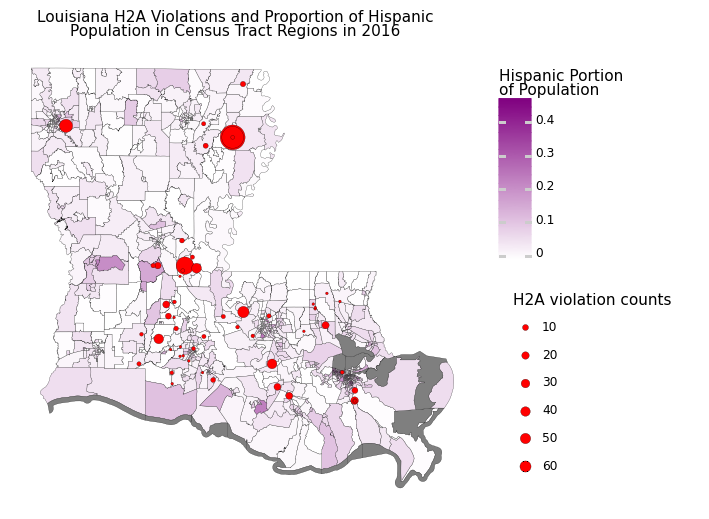

<ggplot: (8782268161377)>

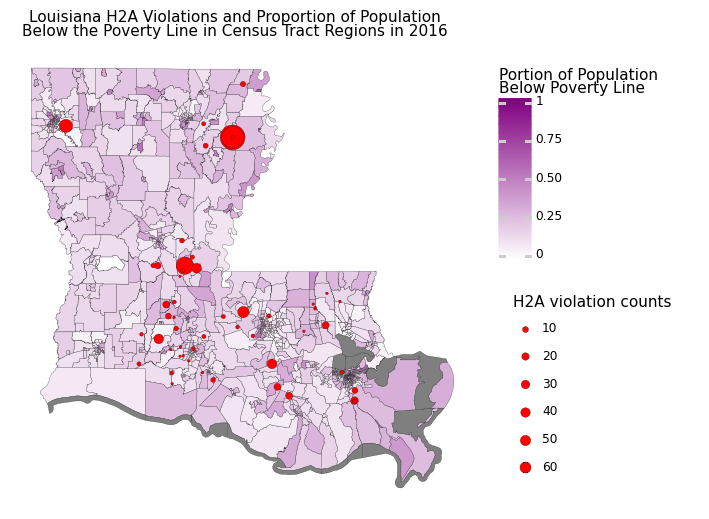

<ggplot: (8782254320704)>

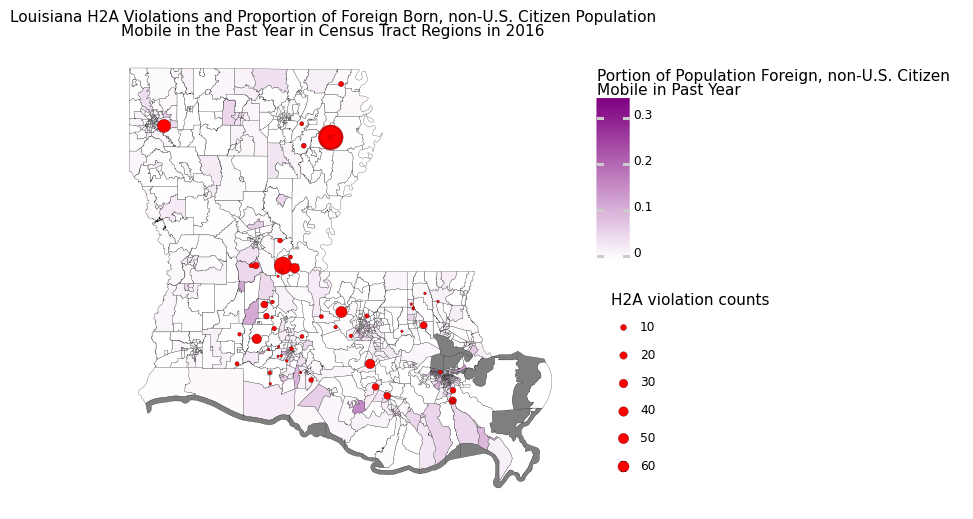

<ggplot: (8782271039257)>

In [195]:
category_plot(louisiana_plot, louisiana_viol, "Louisiana H2A Violations and Proportion of Hispanic\nPopulation in Census Tract Regions in 2016", [6, 6], "perc_hispanic", "Hispanic Portion\nof Population")
category_plot(louisiana_plot, louisiana_viol, "Louisiana H2A Violations and Proportion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [6, 6], "perc_bpl", "Portion of Population\nBelow Poverty Line")
category_plot(louisiana_plot, louisiana_viol, "Louisiana H2A Violations and Proportion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [6, 6], "perc_mobile", "Portion of Population Foreign, non-U.S. Citizen\nMobile in Past Year")




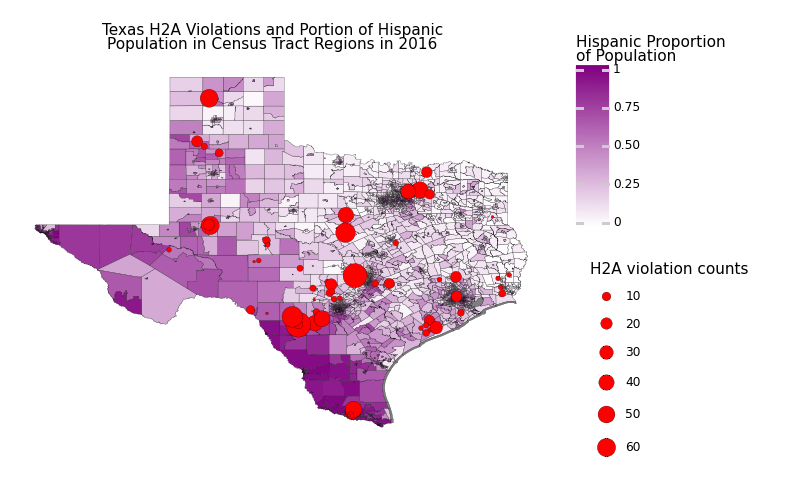

<ggplot: (8782253847751)>

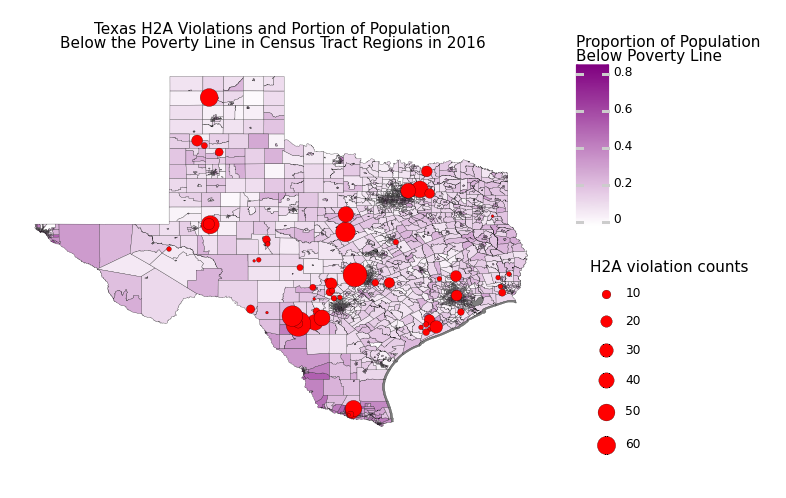

<ggplot: (8782262070128)>

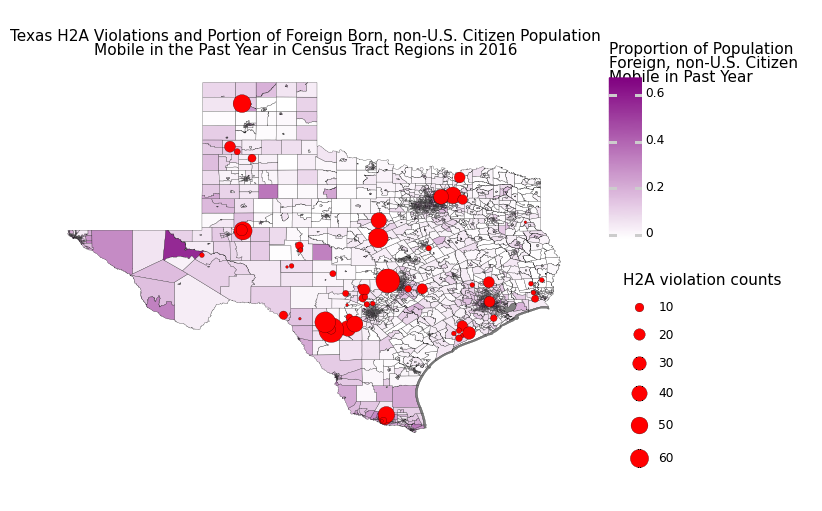

<ggplot: (8782255247565)>

In [196]:
category_plot(texas_plot, texas_viol, "Texas H2A Violations and Portion of Hispanic\nPopulation in Census Tract Regions in 2016", [7, 5], "perc_hispanic", "Hispanic Proportion\nof Population")
category_plot(texas_plot, texas_viol, "Texas H2A Violations and Portion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [7, 5], "perc_bpl", "Proportion of Population\nBelow Poverty Line")
category_plot(texas_plot, texas_viol, "Texas H2A Violations and Portion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [7, 5], "perc_mobile", "Proportion of Population\nForeign, non-U.S. Citizen\nMobile in Past Year")

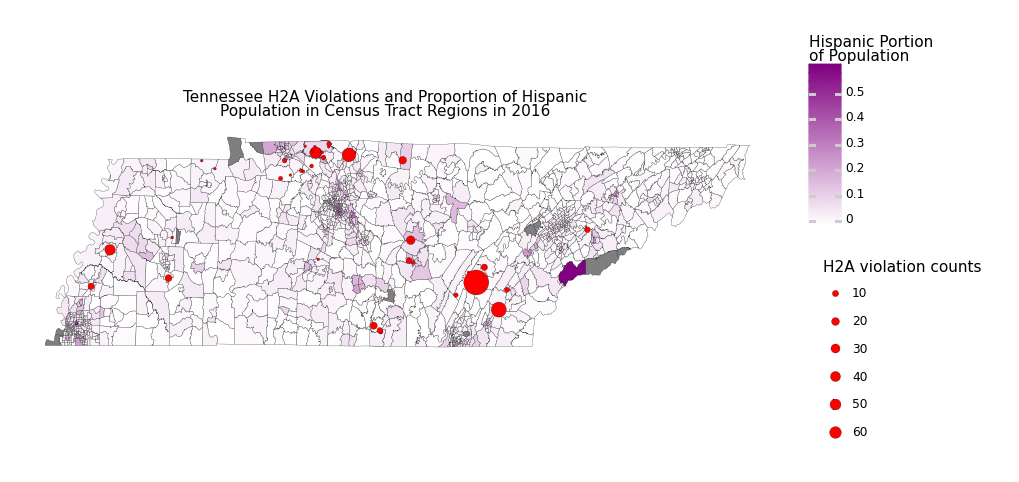

<ggplot: (8782254926553)>

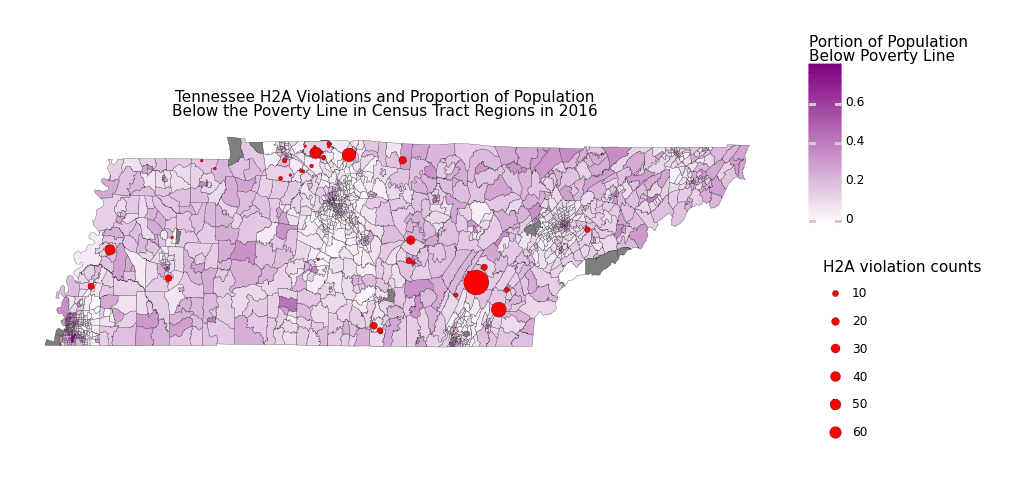

<ggplot: (8782262904411)>

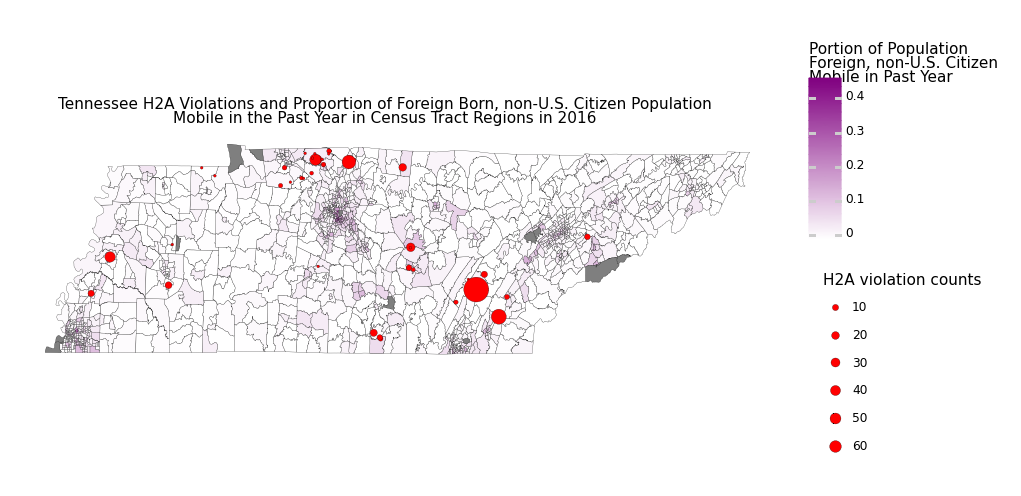

<ggplot: (8782254675881)>

In [197]:
category_plot(ten_plot, ten_viol, "Tennessee H2A Violations and Proportion of Hispanic\nPopulation in Census Tract Regions in 2016", [10, 3], "perc_hispanic", "Hispanic Portion\nof Population")
category_plot(ten_plot, ten_viol, "Tennessee H2A Violations and Proportion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [10, 3], "perc_bpl", "Portion of Population\nBelow Poverty Line")
category_plot(ten_plot, ten_viol, "Tennessee H2A Violations and Proportion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [10, 3], "perc_mobile", "Portion of Population\nForeign, non-U.S. Citizen\nMobile in Past Year")



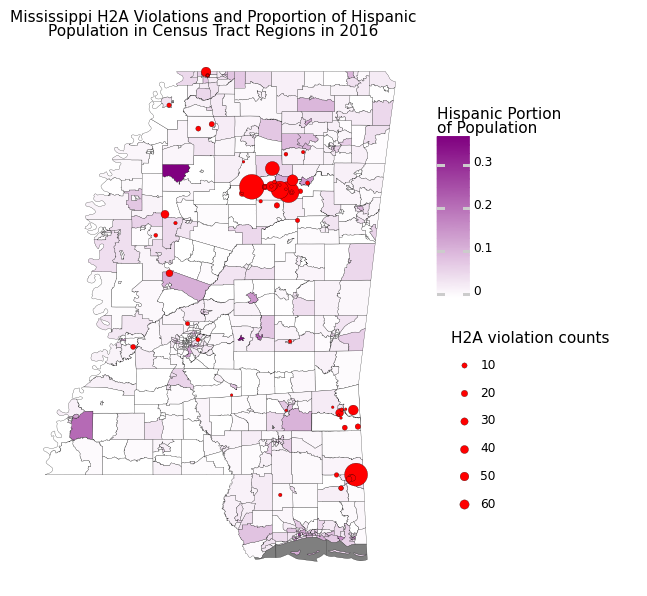

<ggplot: (8782259965847)>

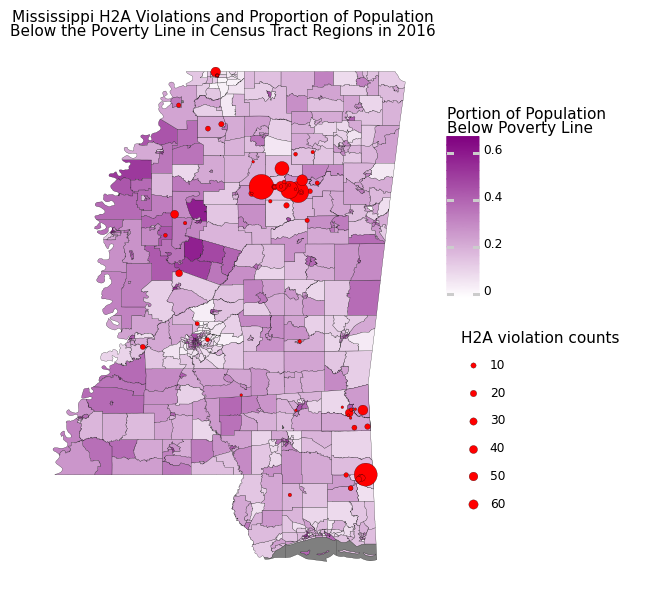

<ggplot: (8782256143680)>

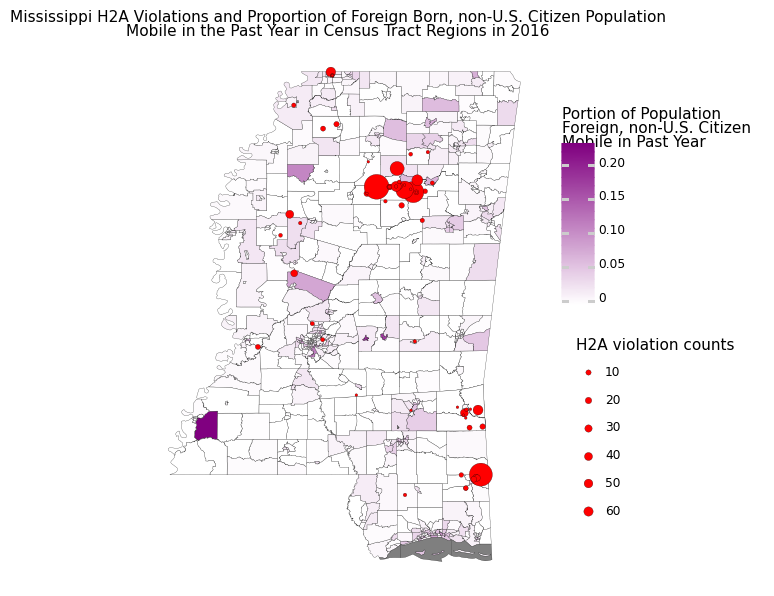

<ggplot: (8782258263655)>

In [198]:
category_plot(miss_plot, miss_viol, "Mississippi H2A Violations and Proportion of Hispanic\nPopulation in Census Tract Regions in 2016", [5, 7], "perc_hispanic", "Hispanic Portion\nof Population")
category_plot(miss_plot, miss_viol, "Mississippi H2A Violations and Proportion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [5, 7], "perc_bpl", "Portion of Population\nBelow Poverty Line")
category_plot(miss_plot, miss_viol, "Mississippi H2A Violations and Proportion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [5, 7], "perc_mobile", "Portion of Population\nForeign, non-U.S. Citizen\nMobile in Past Year")


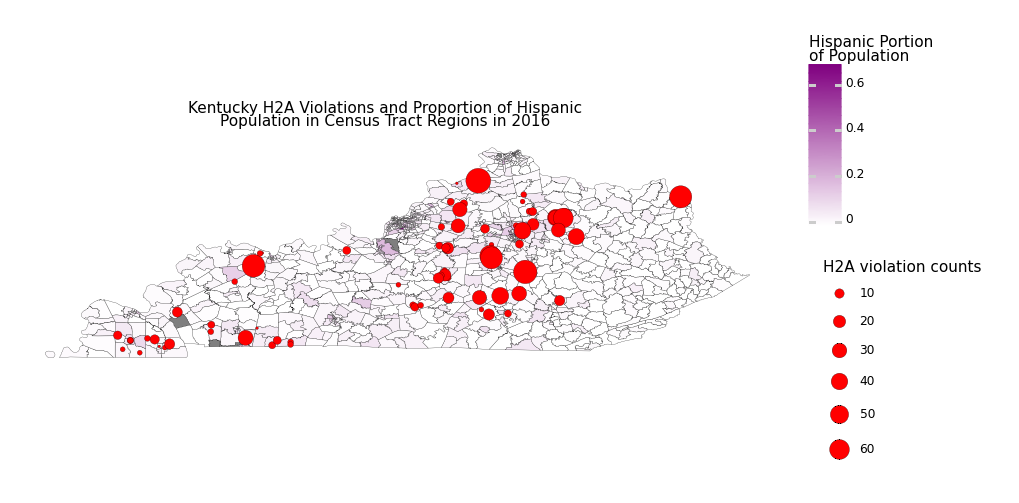

<ggplot: (8782250744998)>

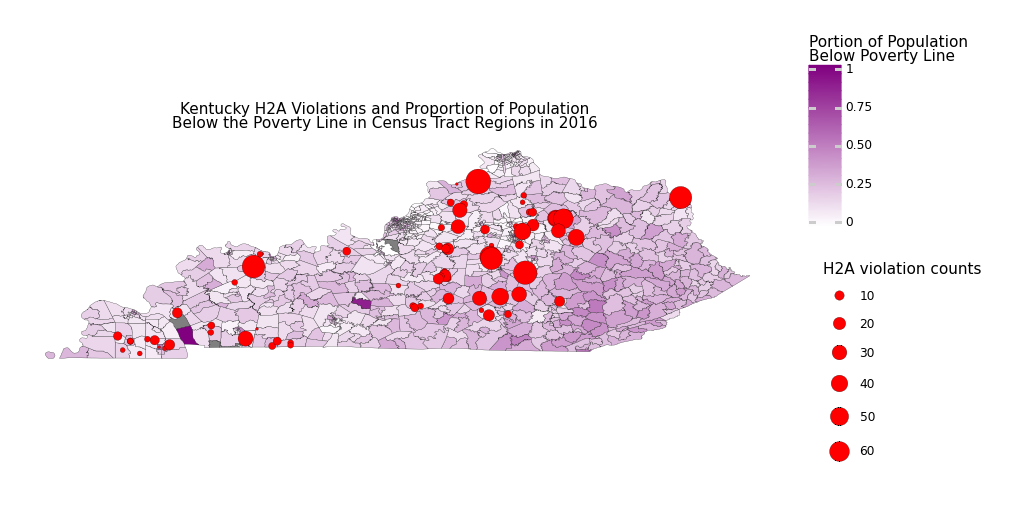

<ggplot: (8782253268342)>

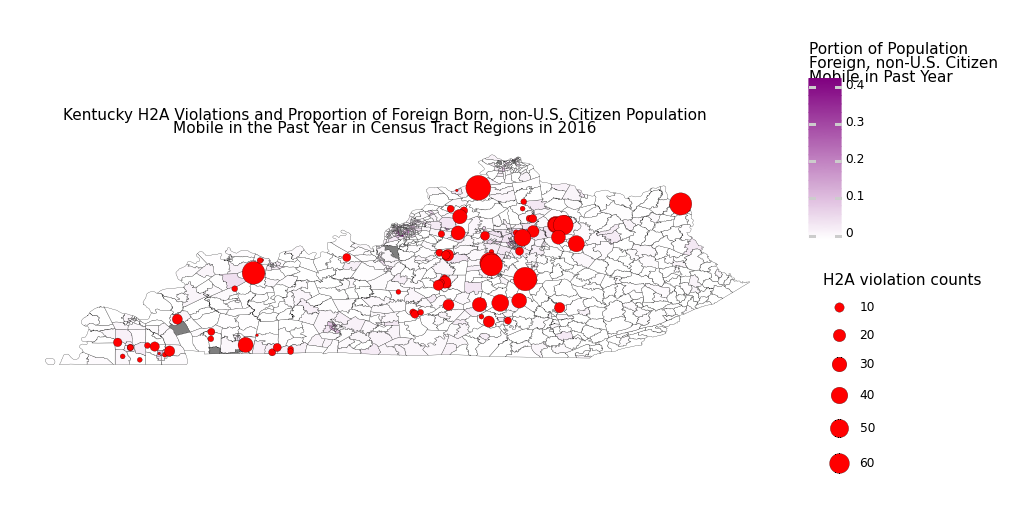

<ggplot: (8782267327537)>

In [199]:
category_plot(ken_plot, ken_viol, "Kentucky H2A Violations and Proportion of Hispanic\nPopulation in Census Tract Regions in 2016", [10, 3], "perc_hispanic", "Hispanic Portion\nof Population")
category_plot(ken_plot, ken_viol, "Kentucky H2A Violations and Proportion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [10, 3], "perc_bpl", "Portion of Population\nBelow Poverty Line")
category_plot(ken_plot, ken_viol, "Kentucky H2A Violations and Proportion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [10, 3], "perc_mobile", "Portion of Population\nForeign, non-U.S. Citizen\nMobile in Past Year")


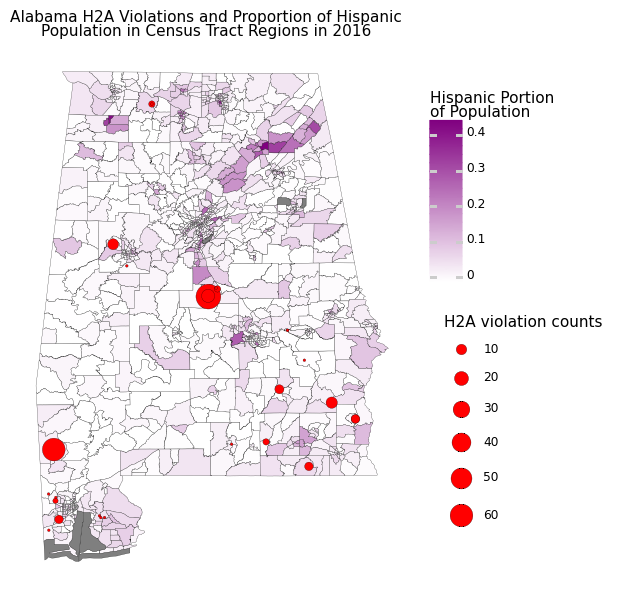

<ggplot: (8782258185232)>

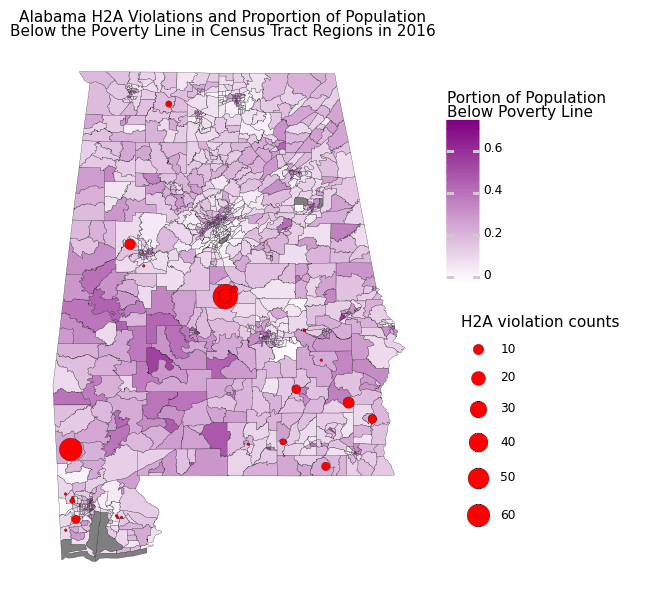

<ggplot: (8782259924252)>

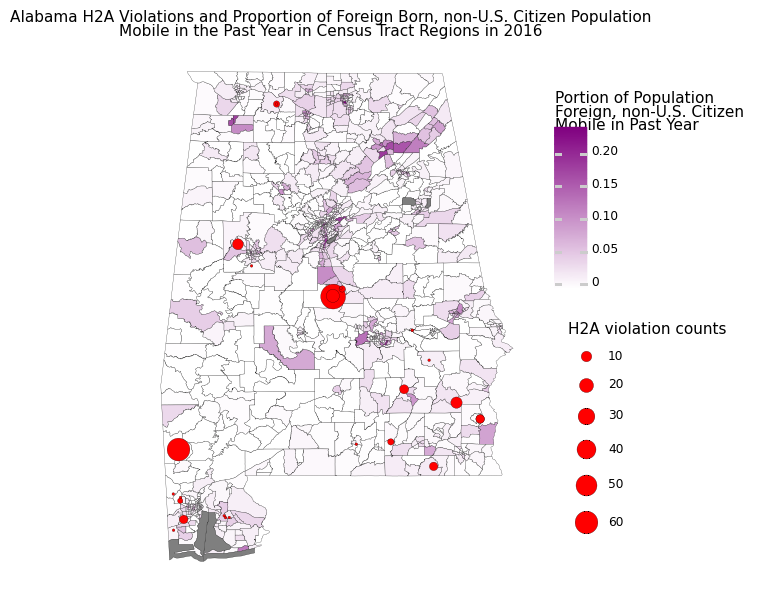

<ggplot: (8782265352147)>

In [200]:
category_plot(alabama_plot, alabama_viol, "Alabama H2A Violations and Proportion of Hispanic\nPopulation in Census Tract Regions in 2016", [5, 7], "perc_hispanic", "Hispanic Portion\nof Population")
category_plot(alabama_plot, alabama_viol, "Alabama H2A Violations and Proportion of Population\nBelow the Poverty Line in Census Tract Regions in 2016", [5, 7], "perc_bpl", "Portion of Population\nBelow Poverty Line")
category_plot(alabama_plot, alabama_viol, "Alabama H2A Violations and Proportion of Foreign Born, non-U.S. Citizen Population\nMobile in the Past Year in Census Tract Regions in 2016", [5, 7], "perc_mobile", "Portion of Population\nForeign, non-U.S. Citizen\nMobile in Past Year")


In [88]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [183]:
from scipy import stats

x = alabama_viol.loc[:,'perc_hispanic'].sort_values().values
y = alabama_viol.loc[:,'h2a_violtn_cnt'].sort_values().values
x2 = alabama_viol.loc[:,'perc_bpl'].sort_values().values

alabama_viol.head()
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
print(rvalue**2)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x2,y)
print(rvalue**2)

case_id  worksite_lat  worksite_long        GEOID  h2a_violtn_cnt  \
0   1860004.0     32.874088     -86.707798  01021060600             1.0   
3   1696089.0     32.773909     -86.719443  01021060600            73.0   
6   1860009.0     32.780891     -86.722257  01021060600            17.0   
9   1860006.0     32.850183     -86.626817  01021060102             3.0   
11  1860016.0     32.858844     -86.640349  01021060102             1.0   

    total_tract_violations  total_tract_investigations_wviol  perc_hispanic  \
0                     91.0                               3.0       0.054638   
3                     91.0                               3.0       0.054638   
6                     91.0                               3.0       0.054638   
9                      4.0                               2.0       0.064841   
11                     4.0                               2.0       0.064841   

    perc_bpl  perc_mobile state_abbrv                    geometry  \
0   0.159149     0.007306          AL  POINT (-86.70780 32.87409)   
3   0.159149     0.007306          AL  POINT (-86.71944 32.77391)   
6   0.159149     0.007306          AL  POINT (-86.72226 32.78089)   
9   0.239526     0.057291          AL  POINT (-86.62682 32.85018)   
11  0.239526     0.057291          AL  POINT (-86.64035 32.85884)   

                      tract_centroid  
0   POINT (-9655658.081 3842016.697)  
3   POINT (-9655658.081 3842016.697)  
6   POINT (-9655658.081 3842016.697)  
9   POINT (-9646617.749 3855047.759)  
11  POINT (-9646617.749 3855047.759)

0.36924633106859023
0.27893036450412256


In [193]:
def linreg(state, column): 
    x = state.loc[:, column].sort_values().values
    y = state.loc[:,'h2a_violtn_cnt'].sort_values().values

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    print(state.reset_index().state_abbrv[0], "R^2 =", rvalue**2)
    #return(slope, intercept, rvalue, pvalue, stderr)

print("perc hispanic")
linreg(ken_viol, "perc_hispanic")
linreg(alabama_viol, "perc_hispanic")
linreg(ten_viol, "perc_hispanic")
linreg(texas_viol, "perc_hispanic")
linreg(miss_viol, "perc_hispanic")
linreg(louisiana_viol, "perc_hispanic")

print("perc below poverty line")
linreg(ken_viol, "perc_bpl")
linreg(alabama_viol, "perc_bpl")
linreg(ten_viol, "perc_bpl")
linreg(texas_viol, "perc_bpl")
linreg(miss_viol, "perc_bpl")
linreg(louisiana_viol, "perc_bpl")

print("perc mobile")
linreg(ken_viol, "perc_mobile")
linreg(alabama_viol, "perc_mobile")
linreg(ten_viol, "perc_mobile")
linreg(texas_viol, "perc_mobile")
linreg(miss_viol, "perc_mobile")
linreg(louisiana_viol, "perc_mobile")

perc hispanic
KY R^2 = 0.8529870207236538
AL R^2 = 0.36924633106859023
TN R^2 = 0.2767871645008051
TX R^2 = 0.7994621478982534
MS R^2 = 0.7063338335477045
LA R^2 = 0.7474848152360318
perc below poverty line
KY R^2 = 0.7380473133359599
AL R^2 = 0.27893036450412256
TN R^2 = 0.5633538602581134
TX R^2 = 0.9286770511565962
MS R^2 = 0.517037497350517
LA R^2 = 0.4400290770129256
perc mobile
KY R^2 = 0.8799326097235793
AL R^2 = 0.6433583765039494
TN R^2 = 0.379074695549861
TX R^2 = 0.9271770113309697
MS R^2 = 0.7897316118119151
LA R^2 = 0.4921064029703156
